# Watershed segmentation for droplet isolation

In [2]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing

import cv2

from scipy import ndimage as ndi

import os

import plotly.graph_objs as go

### Segmentation parameters

In [37]:
exp_clip_limit = 0.06
closing_disk_radius = 4
rm_holes_area = 8192
minima_minDist = 100
mask_val = 0.1

### Read image

(2848, 4288)


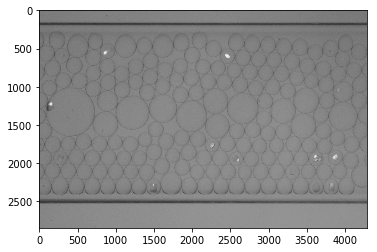

In [4]:
image_file = 'example_data/DSC_2649.JPG'
f = cv2.imread(image_file, 0)
plt.figure(0)
plt.imshow(f, cmap=plt.cm.gray, vmin=0, vmax=255)
print(f.shape)

### Crop area of interest

and convert to uint (for some skimage methods)

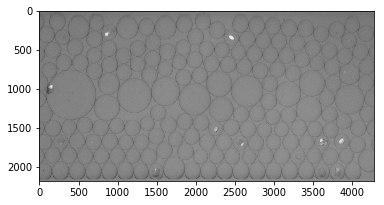

In [7]:
f_cropped = f[250:2430,0:4288] #[lines, columns]
plt.figure(2)
plt.imshow(f_cropped, cmap=plt.cm.gray, vmin=0, vmax=255)

In [8]:
f_cropped.mean()

129.50581267972066

### Increase contrast

Adaptive equalization can deal with some non-uniformity in the original image

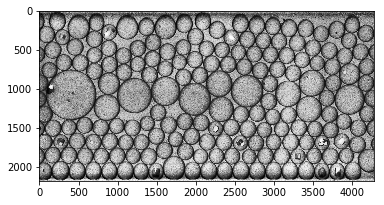

In [9]:
# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(f_cropped, clip_limit = exp_clip_limit)
plt.imshow(img_adapteq, cmap=plt.cm.gray, vmin=0, vmax=1)

# Contrast stretching
#p2, p98 = np.percentile(f_uint, (2, 98))
#img_rescale = exposure.rescale_intensity(f_uint, in_range=(p2, p98))
#plt.imshow(img_rescale, cmap=plt.cm.gray)

### Threshold

Minimum threshold was found to work best in this type of image (see SegmentationDropletsInCapillary).

Minimum threshold: 0.466796875
Min intensity: 0.0
Max intensity: 1.0


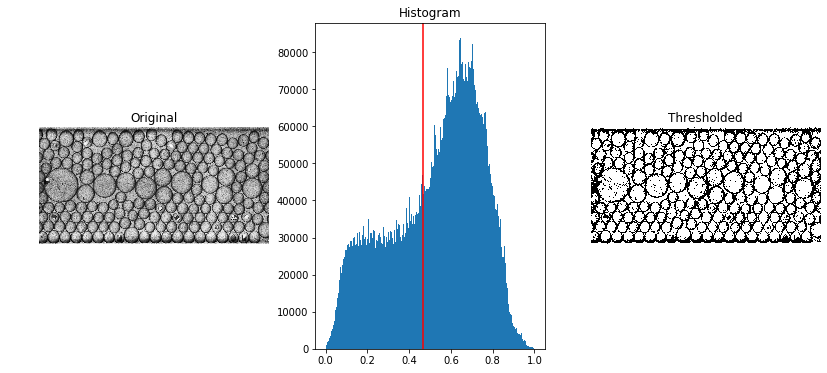

In [10]:
image = img_adapteq

thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(14, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(thresh))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

### Perform Watershed segmentation

- Close to remove artifacts from contrast increase and thresholding
- Calculate the distance image, increase its contrast and mask low distance areas (at the intersection between drops)
- Find local distance maxima and use as markers for watershed
- Run the watershed algorithm to segment
- Label segmented regions

#### Closing and removing small dark spots from crystal borders

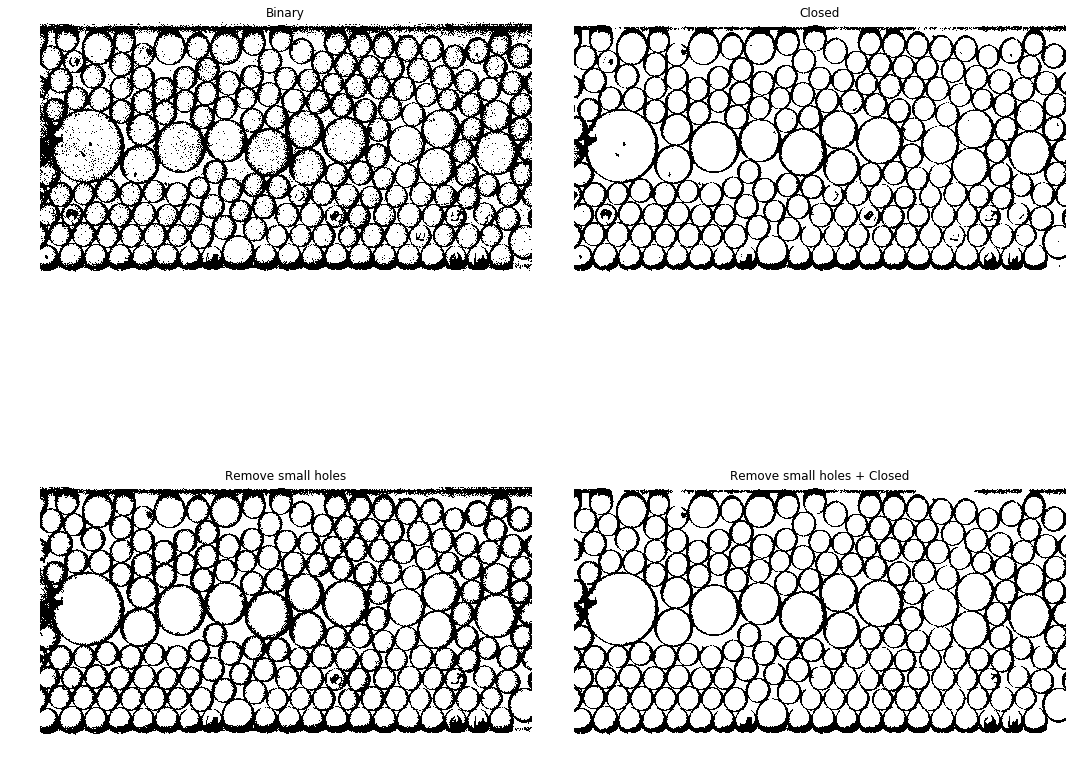

In [46]:
from skimage.morphology  import binary_closing, disk, binary_dilation, remove_small_holes, diameter_closing

# Remove dark spots and connect bright spots
closed = binary_closing(binary, selem=disk(closing_disk_radius))

# Remove small dark regions
rm_holes = remove_small_holes(binary, area_threshold=rm_holes_area, connectivity=2)
rm_holes_closed = remove_small_holes(closed, area_threshold=rm_holes_area, connectivity=2)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Binary')
ax[1].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Closed')
ax[2].imshow(rm_holes, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Remove small holes')
ax[3].imshow(rm_holes_closed, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Remove small holes + Closed')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

#### Calculate distance to background

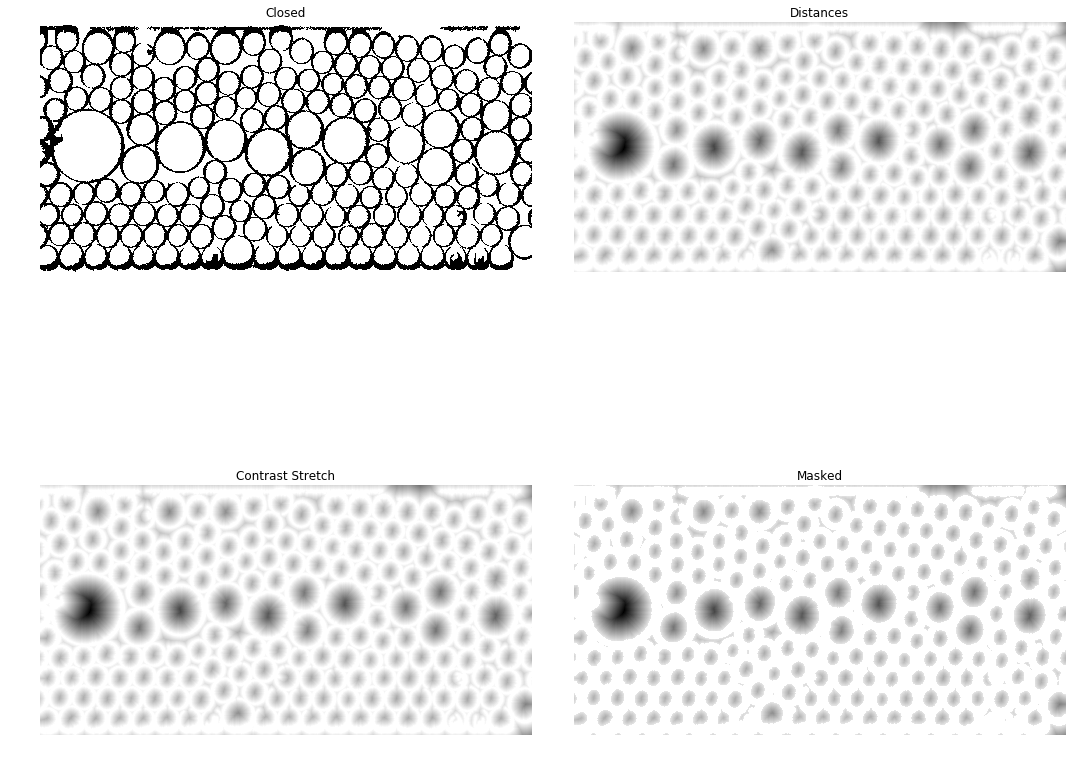

In [39]:
# Starting image from closing process
closed = rm_holes_closed

# Calculate the distance to the dark background
distance = cv2.distanceTransform(closed.astype('uint8'),cv2.DIST_L2,3)

# Increase contrast of the the distance image
cont_stretch = exposure.rescale_intensity(distance, in_range='image')

# Mask the distance image to remove interstitial points
masked = cont_stretch.copy()
masked[masked < mask_val] = 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Closed')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(-cont_stretch, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Contrast Stretch')
ax[3].imshow(-masked, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Masked')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

#### Find local maxima

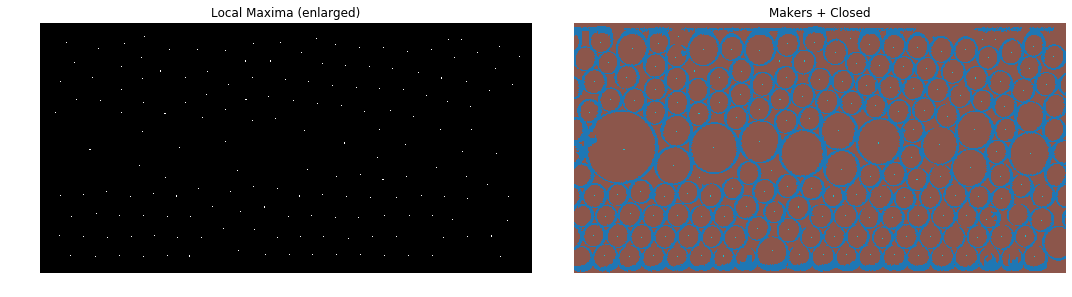

In [40]:
from skimage.morphology import h_maxima

# Distance image to find the maxima on
distance = masked

# Find local maximas of the distance image
local_maxi = peak_local_max(distance, indices=False, min_distance=minima_minDist, threshold_rel=0.2)

markers = np.zeros_like(distance)
markers[closed] = 1
markers[binary_dilation(local_maxi, disk(5))] = 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary_dilation(local_maxi, disk(5)), cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Local Maxima (enlarged)')
ax[1].imshow(markers, cmap=plt.cm.tab10, interpolation='nearest')
ax[1].set_title('Makers + Closed')


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

#### Run Watershed Algorithm

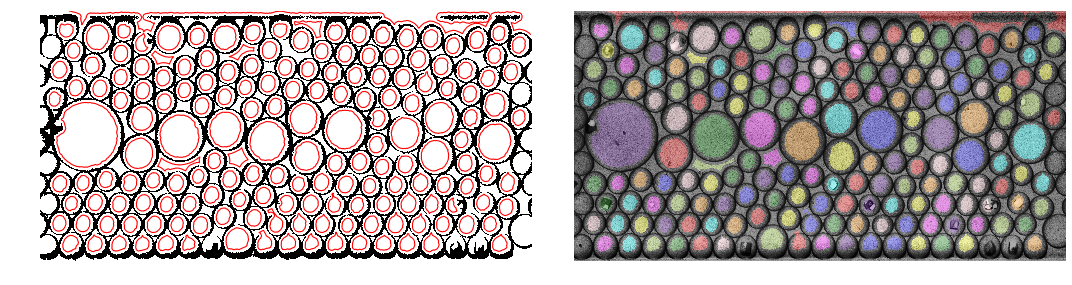

Number of maximas: 181
Number of regions: 175


In [41]:
# Markers for watershed are the local maxima of the distance image
markers, num_max = ndi.label(local_maxi)

# Run watershed algorithm on the inverse of the distance image
#threeChannels = cv2.cvtColor(-masked, cv2.COLOR_GRAY2BGR)
#segmented = cv2.watershed(threeChannels.astype('uint8'), markers)
segmented = watershed(closed, markers, mask = masked > 0)

# Label the segments of the image
labeled, num_sec = ndi.label(segmented)

# Color the labels sections for display
image_label_overlay = label2rgb(labeled, image=image, bg_label=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax = axes.ravel()

axes[0].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(labeled, [0.5], linewidths=1, colors='r')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

print('Number of maximas: ' + str(num_max))
print('Number of regions: ' + str(num_sec))

### Extract the labeled regions

In [42]:
reg = regionprops(labeled, intensity_image=f_cropped, coordinates='rc')
columns= ['Label', 'Area', 'Eccentricity', 'Bbox Area', 'Bbox', 'Centroid', 'Image']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image} for i in reg])
df.head(5)

,Label,Area,Eccentricity,Bbox Area,Bbox,Centroid,Image
0,1.0,156008.0,0.999124,838240.0,"(0, 258, 208, 4288)","(57.367538844161835, 2766.5849315419723)","[[125, 123, 123, 121, 123, 122, 122, 123, 126,..."
1,2.0,12525.0,0.881302,35850.0,"(85, 2224, 235, 2463)","(137.55457085828343, 2382.497245508982)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3.0,10790.0,0.391759,14278.0,"(111, 2041, 232, 2159)","(166.56348470806302, 2098.8615384615387)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4.0,10684.0,0.342604,13804.0,"(112, 174, 228, 293)","(168.0185323848746, 232.0953762635717)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,5.0,9827.0,0.375310,12744.0,"(118, 684, 236, 792)","(176.50401953800753, 735.1509107560802)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


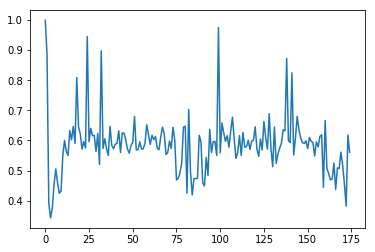

In [43]:
df.Eccentricity.plot()

### Get individual images for each droplet

To be fed in the classification algorithm

#### Display images

175 drops where detected and segmented
167 clean drops with eccentricity < 0.8


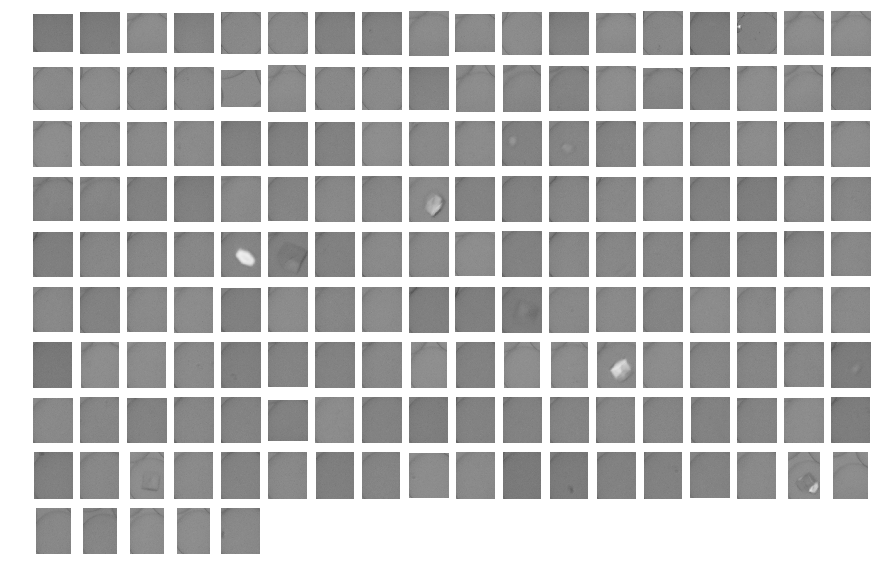

In [44]:
# Display parameters
org_img = f_cropped # Intensity image
border = 25 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.8 # Eccentricity cuttoff, removes misidentified shapes (for instance half-droplets)
max_col = org_img.shape[1]
max_row = org_img.shape[0]

n_img = len(reg)
print("{} drops where detected and segmented".format(n_img))
n_col = 10
n_rows = n_img // n_col + 1

# Sort as a function of eccentricity
reg.sort(key=lambda x: x.eccentricity)
reg_clean = [region for region in reg if (region.eccentricity < ecc_cutoff)]

print("{} clean drops with eccentricity < {}".format(len(reg_clean), ecc_cutoff))

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(reg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    axes[i].imshow(contrast_stretch, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(reg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 10)

#### Save images in corresponding subfolder

In [237]:
# Display parameters
org_img = f_cropped # Intensity image
border = 25 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.75 # Eccentricity cuttoff, removes misidentified shapes (for instance half-droplets)
max_col = org_img.shape[1]
max_row = org_img.shape[0]

# Sort as a function of eccentricity
reg.sort(key=lambda x: x.eccentricity)
reg_clean = [region for region in reg if (region.eccentricity < ecc_cutoff)]

# Create the folder
image_path = image_file.split('.')[0] + '/'

if not os.path.isdir(image_path):
    os.mkdir(image_path)

for i, region in enumerate(reg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    #io.imsave(image_path + 'drop_{}.jpg'.format(i), contrast_stretch)
    


### Display control image

Dummy labels are used in this notebook, trained model will be loaded in actual pipeline

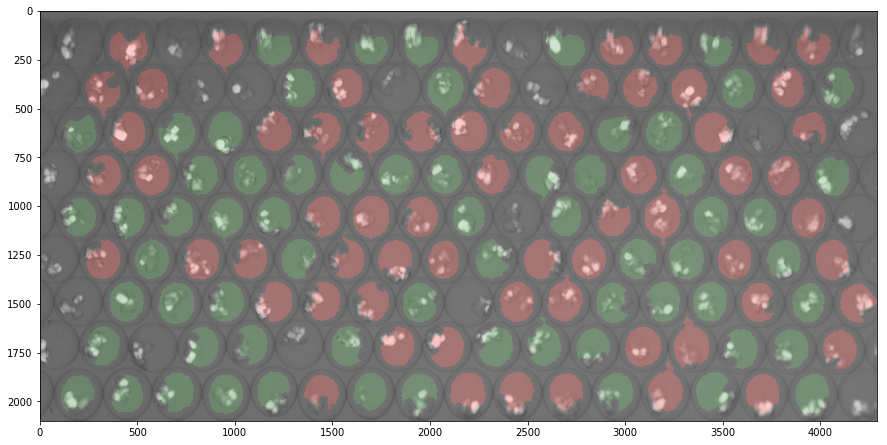

CPU times: user 6.12 s, sys: 817 ms, total: 6.93 s
Wall time: 3.36 s


In [238]:
%%time

orig_image = f_cropped
labeled_binary = np.zeros_like(orig_image)

fig = plt.figure(figsize=(15,10))

for region in reg_clean:
    ## Region label based - 3s
    #labeled_binary[labeled == region.label] = np.random.binomial(1, 0.5)+1
    ## Bounding box based - 2.86s
    #(min_row, min_col, max_row, max_col) = region.bbox
    #labeled_binary[min_row:max_row, min_col:max_col] = np.random.binomial(1, 0.5)+1
    ## Coordinates based - 3s
    #labeled_binary[[*region.coords.T]] = np.random.binomial(1, 0.5)+1 # Version 1 - 3s
    np.put(labeled_binary, np.ravel_multi_index(region.coords.T, labeled_binary.shape), np.random.binomial(1, 0.5)+1) # Version 2 - 3s
    ## Enclosing circle - 5s
    #x = np.arange(0, org_img.shape[1])
    #y = np.arange(0, org_img.shape[0])
    #mask = (x[np.newaxis,:]-region.centroid[0])**2 + (y[:,np.newaxis]-region.centroid[1])**2 < (region.equivalent_diameter/2)**2
    #labeled_binary[mask] = np.random.binomial(1, 0.5)+1
    
overlay_label = label2rgb(labeled_binary, orig_image, colors = ['green', 'red'], alpha=0.2, bg_label=0)

plt.clf()
plt.imshow(overlay_label)
plt.show()

In [239]:
io.imsave('test.jpg', skimage.img_as_ubyte(overlay_label))

/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning:

Possible precision loss when converting from float64 to uint8

